<center>
<img align="center" src="http://sydney.edu.au/images/content/about/logo-mono.jpg">
</center>
<h1 align="center" style="margin-top:10px">Statistical Learning and Data Mining</h1>
<h2 align="center" style="margin-top:20px">Week 13 Tutorial: Deep Learning with PyTorch</h2>
<br>

This tutorial is an introduction to building and training neural networks with [PyTorch](https://pytorch.org/). We'll build a simple feedforward network for fraud detection and train it by stochastic gradient descent.

<a href="#1.-Credit-Card-Fraud-Data">Credit card fraud data</a> <br>
<a href="#2.-Dataset-and-DataLoader">Dataset and DataLoader</a> <br>
<a href="#3.-Building-a-neural-network">Building a neural network</a> <br>
<a href="#4.-Training">Training</a> <br>
<a href="#5.-Logistic-Regression">Logistic regression</a> <br>
<a href="#6.-Validation-results">Validation results</a> <br>

This notebook relies on the following libraries and settings.

In [1]:
# Requirements 

import numpy as np
import scipy 
import pandas as pd
import sklearn
import torch 

print(f'Package versions: \n')

print(f'numpy {np.__version__}')
print(f'scipy {scipy.__version__}')
print(f'pandas {pd.__version__}')
print(f'scikit-learn {sklearn.__version__}')
print(f'torch {torch.__version__}')

# Notebook tested on:

# numpy 1.21.5
# scipy 1.7.1
# pandas 1.3.4
# scikit-learn 1.0.2
# torch 1.11.0

Package versions: 

numpy 1.20.3
scipy 1.7.3
pandas 1.2.5
scikit-learn 1.0.2
torch 1.10.0


In [2]:
# Optional configuration

import warnings
warnings.filterwarnings('ignore') 

In [3]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

# 1. Credit card fraud data

This tutorial will be based on the [credit card fraud dataset](hhttps://www.kaggle.com/mlg-ulb/creditcardfraud) available from [Kaggle Datasets](https://www.kaggle.com/datasets). Our objective is to detect fraudulent credit card transactions using classification methods. 

Let's assume the following loss matrix: 

<table>
  <tr>
    <th>Actual/Predicted</th>
    <th>Legitimate</th>
     <th>Fraud</th>
  </tr>
  <tr>
    <th>Legitimate</th>
    <td>0</td>
    <td>1</td>
  </tr>
  <tr>
    <th>Fraud</th>
    <td>10</td>
    <td>0</td>
  </tr>
</table>

That is, we assume that it is much worse for the financial institution to miss a fraudulent transaction than to flag a legitimate transaction as potential fraud.

We start by loading and inspecting the data. All features except the transaction amount are the result of a principal components analysis (PCA) transformation of undisclosed predictors.

In [4]:
data = pd.read_csv('creditcard.csv')
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


This is a relatively large dataset with 284,807 transactions:

In [5]:
print(data.shape)

(284807, 31)


The classes are highly imbalanced: only 492 transactions (0.17%) are fraudulent.  This makes the problem much more challenging than the total number of observations would suggest.

In [6]:
data['Class'].value_counts()

0    284315
1       492
Name: Class, dtype: int64

With so few observations in the fraud class, we should ideally use cross-validation throughout the analysis. However, this would excessively complicate the code, and we simply create a validation set.

In [7]:
response = 'Class'
index_train, index_val = train_test_split(np.array(data.index), stratify=data[response], 
                                          train_size=0.8, random_state=1)

predictors = list(data.columns[1:-1])  # we won't use the  time variable

X_train = data.loc[index_train, predictors].to_numpy()
y_train = data.loc[index_train, response].to_numpy()

X_valid = data.loc[index_val, predictors].to_numpy()
y_valid = data.loc[index_val, response].to_numpy()

The last step that we need to prepare the data is to standardise the predictors.

In [8]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_valid = scaler.transform(X_valid)

# 2. Dataset and DataLoader

When working with PyTorch, we need to tell it how to process the data and construct minibatches for stochastic gradient descent. 

The first step is to create a PyTorch dataset object. The easiest way to do this in our case is to convert the original NumPy arrays into PyTorch [tensors](https://pytorch.org/docs/stable/tensors.html), the format required by the package, and then use the [TensorDataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset) function to create the dataset.

A tensor in this context is just another name for an array. The PyTorch documentation writes:

> A `torch.Tensor` is a multi-dimensional matrix containing elements of a single data type.

In [9]:
from torch.utils.data import TensorDataset

trainset = TensorDataset(torch.from_numpy(X_train).float(), torch.from_numpy(y_train).float())
validset = TensorDataset(torch.from_numpy(X_valid).float(), torch.from_numpy(y_valid).float())

 In many cases, you'll need to create a custom dataset. A PyTorch dataset must be a class that implements three methods: `__init__`, `__len__`, and `__getitem__`. The first takes data as an input, processes it as required, and instantiates the `DataSet` object. The second returns the number of observations. The third takes an index as an input and returns the observation that corresponds to that index.

In [10]:
from torch.utils.data import Dataset

class FraudDataset(Dataset):
    
    def __init__(self, X, y):
        self.input = torch.from_numpy(X).float()
        self.target = torch.from_numpy(y).float()

    def __len__(self):
        return len(self.target)

    def __getitem__(self, idx):
        return self.input[idx, :], self.target[idx]
    
trainset = FraudDataset(X_train, y_train)

A [DataLoader](https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader) takes a `DataSet` as an input and creates an iterator that allows PyTorch to process the data in batches.

 Setting the `shuffle` option to `True` makes the DataLoader reshuffle the data at every epoch.

In [11]:
from torch.utils.data import DataLoader

trainloader = DataLoader(trainset, batch_size=1024, shuffle=True)

The next cell grabs a randomly sampled mini-batch for inspection.

In [16]:
X, y = next(iter(trainloader))

X

tensor([[-0.1361,  0.6230,  0.3034,  ..., -0.0970, -0.2962, -0.3064],
        [-0.8357,  0.3011,  0.9927,  ..., -0.1898, -0.0802,  0.1593],
        [-0.4191,  0.6526,  0.7345,  ...,  0.5310,  0.4235, -0.1149],
        ...,
        [-1.6528,  0.4803,  0.5746,  ..., -1.0794, -1.3220,  0.0580],
        [-0.3112,  0.2711,  0.8499,  ..., -0.8057, -1.0689, -0.2748],
        [-0.1912,  0.3677, -1.1958,  ..., -0.9205, -1.0006, -0.1599]])

In [17]:
y

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [13]:
X.shape

torch.Size([1024, 29])

In [14]:
y.shape

torch.Size([1024])

# 3. Building a neural network

Our neural network model will be a multilayer perceptron (MLP) with three hidden layers. Each layer will have 128 hidden units and the activation function will be the rectified linear unit (ReLU).

We code the model as a PyTorch neural network module that is a subclass of [nn.Module](https://pytorch.org/docs/stable/generated/torch.nn.Module.html). The model class needs to have an `__init__` method that initialises the neural network layers and a `forward` method that implements the operations to be performed on the inputs.

The following code takes advantage of the `nn.Sequential` class, which allows us to quickly stack standard layers.

In [19]:
X_train.shape

(227845, 29)

In [26]:
from torch import nn
   
class NeuralNetwork(nn.Module):
    
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        
        self.feedforward = nn.Sequential(            
            nn.Linear(29, 128),  # 28 -> 128 -> ReLU -> 128 -> ReLU -> 128 -> ReLU -> 1 -> Sigmoid
            nn.ReLU(),                       
            nn.Linear(128, 128),
            nn.ReLU(),  
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1),
            nn.Sigmoid()
        )                        

    def forward(self, X):        
        return self.feedforward(X).flatten() # returns a flat array as desired

We instantiate the model as follows.

In [27]:
mlp = NeuralNetwork()

print(mlp)

NeuralNetwork(
  (feedforward): Sequential(
    (0): Linear(in_features=29, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


The [torchinfo](https://github.com/TylerYep/torchinfo) package provides a more detailed model summary.  We need to pass the input size (including the batch size) for it to work out how each layer processes the data.

In [28]:
from torchinfo import summary

summary(mlp, input_size=(64, 29))

Layer (type:depth-idx)                   Output Shape              Param #
NeuralNetwork                            --                        --
├─Sequential: 1-1                        [64, 1]                   --
│    └─Linear: 2-1                       [64, 128]                 3,840
│    └─ReLU: 2-2                         [64, 128]                 --
│    └─Linear: 2-3                       [64, 128]                 16,512
│    └─ReLU: 2-4                         [64, 128]                 --
│    └─Linear: 2-5                       [64, 128]                 16,512
│    └─ReLU: 2-6                         [64, 128]                 --
│    └─Linear: 2-7                       [64, 1]                   129
│    └─Sigmoid: 2-8                      [64, 1]                   --
Total params: 36,993
Trainable params: 36,993
Non-trainable params: 0
Total mult-adds (M): 2.37
Input size (MB): 0.01
Forward/backward pass size (MB): 0.20
Params size (MB): 0.15
Estimated Total Size (MB): 0.35

# 4. Computing predictions

At the most basic level, computing the output of the model given input data is just a matter of running a command such as `output = model(X)`. 

In practice, we need to handle a few practical details such as moving the data to the GPU memory. We write a function to take care of the details.

In [29]:
X_train

array([[ 0.58867204, -0.00190627, -0.15430595, ..., -0.02083907,
        -0.03400482, -0.11962486],
       [-0.46600498, -0.59279613,  0.68102923, ..., -0.32153323,
        -0.48878674,  0.21434073],
       [ 0.62651986,  0.30118025, -0.05618417, ..., -0.01819322,
         0.01123113, -0.32284392],
       ...,
       [ 1.01467248,  0.06443548, -0.61140049, ...,  0.18057578,
        -0.01692782, -0.32320388],
       [ 0.96789021, -0.12132428, -0.26700661, ...,  0.12197599,
        -0.10052038, -0.32020419],
       [ 0.53491683, -1.0159783 , -0.26833026, ..., -0.12881622,
         0.1339857 ,  0.70081061]])

In [30]:
def predict(net, X):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Move data to device
    X_g = X.to(device)
    
    # Put model on evaluation mode (it makes no difference but needed in some cases)
    net.eval()
    
    # Disable gradient computation
    with torch.no_grad():
        
        # Predicted probabilities 
        # the .cpu().detach() part transfers the result to the cpu
        output = net(X_g).cpu().detach()
    
    return output # the output is a tensor

# 4. Training

Let's train our neural network! 

So far in this unit, we trained our models using simple commands such as `model.fit(X_train, y_train)`. Training models with PyTorch more coding, so we implement a function to train the model. I annotated all the steps are annotated so that you can understand the details.

In [19]:
import time

def train(model, trainloader, validset, num_epochs = 5 , lr = 1e-3):
    
    # Get device
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Instantiate model and move to device
    net = model().to(device)
    
    # Loss function
    loss_fn = nn.BCELoss() # binary cross-entropy loss, assumes that the output of the network is a probability
    
    # Instantiate optimiser
    # Adam is a variant of SGD that often works well for training neural networks
    # https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
    optimiser = torch.optim.Adam(net.parameters(), lr=lr) 
    
    # Addding a learning rate scheduler to improve training
    # Adam + OneCycleLR is a good default for many problems
    # Learn more: https://sgugger.github.io/the-1cycle-policy.html
    scheduler = torch.optim.lr_scheduler.OneCycleLR(optimiser, max_lr=lr, 
                                                    steps_per_epoch=len(trainloader), epochs=num_epochs,
                                                    three_phase=True)
    # Number of training samples
    num_samples = len(trainloader.dataset)
    
    # Initialise table to track training
    table = init_training_table(num_epochs)
    
    # Training loop
    print('Running first epoch')
    for epoch in range(num_epochs):
        
        # Make sure that the model is on training mode
        net.train()
        
        # Initialise timer
        epoch_start = time.time()
        
        # Initialise metric
        train_loss = 0.0
        
        # Iterate over minibatches
        for X, y in trainloader:

            # Move minibatch to device
            X_g = X.to(device)
            y_g = y.to(device)

            # Reset the gradient
            optimiser.zero_grad()

            # Compute predictions
            output = net(X_g)

            # Evaluate cost function
            loss = loss_fn(output, y_g)

            # Compute gradient 
            loss.backward()

            # Update parameters
            optimiser.step()
            
            # Update scheduler
            scheduler.step()
            
            # Keep track of the training loss
            l = loss.cpu().detach().numpy()
            train_loss +=  l*(len(y)/num_samples)
  
        # Epoch length
        duration = time.time() - epoch_start 
        
        # Display metrics
        table.iloc[epoch, 1] = np.round(10*train_loss, 3)
        table = update_training_table(table, net, validset, epoch, duration)
    
    return net

The following is auxiliary code to display the training progress. This code is not important, so let's just run it and proceed.

In [20]:
# auxiliary code

from torch.nn import functional as F
from sklearn.metrics import recall_score, average_precision_score

def evaluate(net, validset):
    
    # Use GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    # Set model to evaluation mode (not necessary here but required in general)
    net.eval()
    
    # Get input and target
    X, y = validset[:]
        
    # Predicted probabilities 
    output = predict(net, X)
        
    # Validation loss
    loss = F.binary_cross_entropy(output, y).item()
    
    # Convert output to numpy
    y_prob = output.numpy()
     
    # Classification using the decision threshold
    tau = 1/11
    y_pred = (y_prob > tau).astype(int)
    
    # Validation metrics
    recall = recall_score(y_valid, y_pred)
    average_precision = average_precision_score(y_valid, y_prob)
    
    return loss, recall, average_precision 


from IPython.display import clear_output
from IPython.display import display, HTML

def init_training_table(num_epochs):
    table = pd.DataFrame(np.arange(1, num_epochs+1), columns = ['epoch'])
    table['train loss'] = 0.0
    table['valid loss'] = 0.0
    table['valid recall'] = 0.0
    table['valid average precision'] = 0.0
    table['time'] = ''
    return table

def update_training_table(table, net, validset, epoch, duration):
    
    # Run evaluation function to get validation metrics
    valid_loss, valid_recall, valid_ave_precision = evaluate(net, validset)
        
    # Update table
    table.iloc[epoch, 2] = np.round(10*valid_loss, 3)
    table.iloc[epoch, 3] = np.round(valid_recall, 3)
    table.iloc[epoch, 4] = np.round(valid_ave_precision, 3)
     
    # Epoch length   
    if duration > 3600:
        table.iloc[epoch, 5] = time.strftime('%H:%M:%S', time.gmtime(duration))
    else:
        table.iloc[epoch, 5] = time.strftime('%M:%S', time.gmtime(duration))
        
    clear_output(wait=True)
    display(HTML(table.iloc[:epoch+1, :].to_html(index=False)))
    
    return table

Choosing a good learning rate is critical in deep learning. Fortunately, the [learning rate finder](https://github.com/davidtvs/pytorch-lr-finder) proposed in [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186) by Leslie N. Smith can help us with this.

The idea is to start training the model with a learning rates that range from very small to somewhat large. We then plot the training error against the learning rate and pick a value before the minimum. We want to choose a value in a range where there's a good improvement in the loss, but not so high that the learning rate may cause instability.  The minimum is too high since it's on the edge of instability, so we choose a learning rate one order of magnitude below.

See this [blog post](https://sgugger.github.io/how-do-you-find-a-good-learning-rate.html#how-do-you-find-a-good-learning-rate) for a detailed explanation.


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 2.85E-03


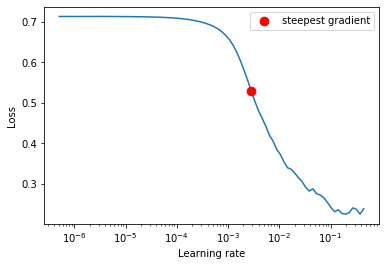

In [21]:
from torch_lr_finder import LRFinder

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = NeuralNetwork()
loss_fn =  nn.BCELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=1e-7)
lr_finder = LRFinder(model, optimiser, loss_fn, device = device)
lr_finder.range_test(trainloader, end_lr=1, num_iter=100)
lr_finder.plot() 
lr_finder.reset() 

Now we can finally train the model.

In [22]:
mlp = train(NeuralNetwork, trainloader, validset, num_epochs=10, lr=3e-3)

epoch,train loss,valid loss,valid recall,valid average precision,time
1,1.740,0.066,0.694,0.704,00:02
2,0.044,0.025,0.857,0.850,00:02
3,0.034,0.023,0.888,0.879,00:02
4,0.031,0.023,0.878,0.882,00:02
5,0.025,0.022,0.898,0.889,00:02
6,0.022,0.022,0.898,0.889,00:02
7,0.020,0.021,0.898,0.891,00:02
8,0.020,0.021,0.898,0.890,00:02
9,0.020,0.021,0.898,0.890,00:02
10,0.020,0.021,0.898,0.890,00:02


You will not get the same numbers because of the randomness in the learning algorithm. When using the CPU for training, it's possible to achieve reproducibility by following the [recommendations](https://pytorch.org/docs/stable/notes/randomness.html) in the PyTorch documentation. With GPU training, reproducibility is difficult and often not possible. 

#  5. Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

# No regularisation
logit = LogisticRegression(penalty='none', solver='lbfgs')
logit.fit(X_train, y_train)

# L2 regularisation
# logit_l2= LogisticRegressionCV(Cs = 50, penalty='l2', solver='lbfgs', scoring='neg_log_loss', n_jobs=-1)
logit_l2= LogisticRegressionCV(Cs=50, penalty='l2', solver='lbfgs', scoring='neg_log_loss')
logit_l2.fit(X_train, y_train)

LogisticRegressionCV(Cs=50, scoring='neg_log_loss')

# 6. Validation results

The next cell compares the validation performance of the neural network against the logistic regression benchmark. The neural network outperforms the logistic regression in terms of the actual loss, average precision, and cross-entropy. 

Some important comments:

(i) As noted above, you will not get the same numbers because of the randomness in the optimisation process. 

(ii) A useful trick for training neural networks is to re-run the learning algorithm if necessary. You can then select and save a model that performs well on the validation set. The disadvantage of this approach is that it can overfit the validation set. If possible, it's better to average multiple neural networks trained on different training-validation splits, discarding those with poor validation performance. 

(iii) The comparison with the logistic regression is not entirely rigorous since we looked at the validation performance to select a reasonable number of epochs for training the neural network.

(iv) It's not clear why the neural networks performs better. As earlier in the unit, it's important to use EDA and interpretability tools to understand what's happening. 

In [25]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, log_loss

columns=['Actual loss', 'Error rate', 'Sensitivity', 'Specificity', 
         'Precision', 'Average Precision', 'Cross-entropy']
rows=['Logistic', 'Logistic $\ell_2$', 'Neural network']
results=pd.DataFrame(0.0, columns=columns, index=rows) 

methods=[logit, logit_l2, None]

lfp = 1
lfn = 10
tau = lfp/(lfp+lfn)

for i, method in enumerate(methods):
    
    if i<2:
        y_prob = method.predict_proba(X_valid)[:, 1]
    else:
        X = validset[:][0]
        y_prob = predict(mlp, X).numpy()
        y_prob[y_prob < 1e-5] = 1e-5 # Log-loss returns NaN if too close to zero or one
        y_prob[y_prob > 1 - 1e-5] =  1- 1e-5
        

    y_pred = (y_prob > tau).astype(int)
       
    tn, fp, fn, tp = confusion_matrix(y_valid, y_pred).ravel()
    
    results.iloc[i,0] = (fp*lfp+fn*lfn)/len(y_valid)
    results.iloc[i,1] = 1 - accuracy_score(y_valid, y_pred)
    results.iloc[i,2] = tp/(tp+fn)
    results.iloc[i,3] = tn/(tn+fp)
    results.iloc[i,4] = precision_score(y_valid, y_pred)
    results.iloc[i,5] = average_precision_score(y_valid, y_prob)
    results.iloc[i,6] = 10*log_loss(y_valid, y_prob)

results.iloc[:,0] /= results.iloc[0,0]
results.round(3)

,Actual loss,Error rate,Sensitivity,Specificity,Precision,Average Precision,Cross-entropy
Logistic,1.000,0.001,0.827,1.000,0.802,0.811,0.033
Logistic $\ell_2$,1.000,0.001,0.827,1.000,0.802,0.815,0.033
Neural network,0.695,0.001,0.898,0.999,0.733,0.890,0.021
